# Seasonal Averages

In [140]:
library(tidyverse)
library(dplyr)
library(ggplot2)

In [85]:
Sys.setlocale("LC_TIME","C")
options(stringsAsFactors=FALSE)
theme_set(theme_bw()) # just my preference for plots

[1] "C"

In [86]:
read_met <- function(filename) {
  data <- read_table(filename, skip=15, 
    col_names= c("year", "month", "day", "hour", "minute", "WIRI", "WIGE"),
    col_types = paste(collapse = "", c(rep("i", 5), rep("n", 2))))
  data %>%
    mutate(datetime = make_datetime(year, month, day, hour, minute, tz = "CEST"),
           year     = year(datetime),
           month    = month(datetime),
           day      = day(datetime),
           hour     = hour(datetime),
           minute   = minute(datetime),
           WIRI     = ifelse(WIRI <= -9999, NA, WIRI),
           WIGE     = ifelse(WIGE <= -9999, NA, WIGE))
}

In [87]:
month2season <- function(month) {
  ## month is an integer (1-12)
  ## a factor with levels {"Winter : DJF", "Spring : MAM", "Summer : JJA", "Autumn : SON"} is returned
  seasons <- c("Winter", "Spring", "Summer", "Autumn")
  index <- findInterval(month %% 12, seq(0, 12, 3))
  factor(seasons[index], seasons)
}

wday2type <- function(wday) {
  ## wday is an integer with 1 = Monday, 2 = Tuesday, ... and 7 = Sunday
  c("Weekday", "Weekend")[(unclass(wday) - 1) %/% 5 + 1]
}

In [88]:
read_tseries <- function(filename, timecolumn = "Date/time", timeformat = "%d.%m.%Y %H:%M", tz = "Etc/GMT-1", delta = 3600) {
  ## read the table, strip units in column names, rename time column
  ##   and change data type of time column from a string of characters to
  ##   a numeric type so that we can perform operations on it

  data <- read_delim(filename, skip = 5, delim = ";", locale = locale(encoding = "Latin1"), show_col_types = FALSE)

  out <- data %>%
    rename_with(.fn = function(x) sub("[ ].*$", "", x)) %>% # strip units for simplification
    rename(datetime = !!timecolumn) %>%
    mutate(datetime = parse_date_time(datetime, !!timeformat, !!tz) - !!delta) %>%
    mutate(year = year(datetime),
           month = month(datetime),
           day = day(datetime),
           hour = hour(datetime),
           dayofwk = wday(datetime, label = TRUE, week_start = 1),
           daytype = wday2type(dayofwk),
           season = month2season(month),
           .after = datetime)
}

In [89]:
datapath <- file.path("Data")

all_data_df <- full_join(
  bind_cols(site="DAV", read_tseries(file.path(datapath, "DAV.csv"))),
  bind_cols(site="BAS", read_tseries(file.path(datapath, "BAS.csv")))
)

Joining with `by = join_by(site, datetime, year, month, day, hour, dayofwk, daytype, season,
O3, NO2, PM10, NOX, TEMP, PREC, RAD)`


In [90]:
all_data_df

site,datetime,year,month,day,hour,dayofwk,daytype,season,O3,NO2,PM10,NOX,TEMP,PREC,RAD,SO2,PM2.5,EC,CPC
<chr>,<dttm>,<dbl>,<dbl>,<int>,<int>,<ord>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DAV,2024-01-01 00:00:00,2024,1,1,0,Mon,Weekday,Winter,57.7,1.9,1.2,1.9,-2.2,0,-0.6,NA,NA,NA,NA
DAV,2024-01-01 01:00:00,2024,1,1,1,Mon,Weekday,Winter,55.2,2.1,1.5,2.1,-2.8,0,-0.7,NA,NA,NA,NA
DAV,2024-01-01 02:00:00,2024,1,1,2,Mon,Weekday,Winter,49.9,3.7,2.2,3.7,-3.3,0,-0.7,NA,NA,NA,NA
DAV,2024-01-01 03:00:00,2024,1,1,3,Mon,Weekday,Winter,52.1,4.5,3.0,4.6,-4.2,0,-1.1,NA,NA,NA,NA
DAV,2024-01-01 04:00:00,2024,1,1,4,Mon,Weekday,Winter,65.8,0.7,0.2,0.7,-5.2,0,-1.3,NA,NA,NA,NA
DAV,2024-01-01 05:00:00,2024,1,1,5,Mon,Weekday,Winter,67.1,0.7,0.4,0.7,-5.6,0,-0.8,NA,NA,NA,NA
DAV,2024-01-01 06:00:00,2024,1,1,6,Mon,Weekday,Winter,64.0,3.4,0.3,3.5,-5.7,0,-0.6,NA,NA,NA,NA
DAV,2024-01-01 07:00:00,2024,1,1,7,Mon,Weekday,Winter,58.4,5.4,0.3,5.4,-5.9,0,-0.6,NA,NA,NA,NA
DAV,2024-01-01 08:00:00,2024,1,1,8,Mon,Weekday,Winter,61.8,1.7,0.3,1.8,-5.7,0,22.6,NA,NA,NA,NA


In [91]:
write.csv(all_data_df, "DATA/DAV-BAS.csv")

In [92]:
all_data_lf <- all_data_df %>%
  pivot_longer(-c(site, datetime, season, year, month, day, hour, dayofwk, daytype),  # id columns
               names_to = "variable",
               values_to = "value")

## Seasonal variations

In [93]:
all_data_lf

site,datetime,year,month,day,hour,dayofwk,daytype,season,variable,value
<chr>,<dttm>,<dbl>,<dbl>,<int>,<int>,<ord>,<chr>,<fct>,<chr>,<dbl>
DAV,2024-01-01 00:00:00,2024,1,1,0,Mon,Weekday,Winter,O3,57.7
DAV,2024-01-01 00:00:00,2024,1,1,0,Mon,Weekday,Winter,NO2,1.9
DAV,2024-01-01 00:00:00,2024,1,1,0,Mon,Weekday,Winter,PM10,1.2
DAV,2024-01-01 00:00:00,2024,1,1,0,Mon,Weekday,Winter,NOX,1.9
DAV,2024-01-01 00:00:00,2024,1,1,0,Mon,Weekday,Winter,TEMP,-2.2
DAV,2024-01-01 00:00:00,2024,1,1,0,Mon,Weekday,Winter,PREC,0.0
DAV,2024-01-01 00:00:00,2024,1,1,0,Mon,Weekday,Winter,RAD,-0.6
DAV,2024-01-01 00:00:00,2024,1,1,0,Mon,Weekday,Winter,SO2,NA
DAV,2024-01-01 00:00:00,2024,1,1,0,Mon,Weekday,Winter,PM2.5,NA


Warning message:
"Removed 17568 rows containing missing values (`geom_line()`)."


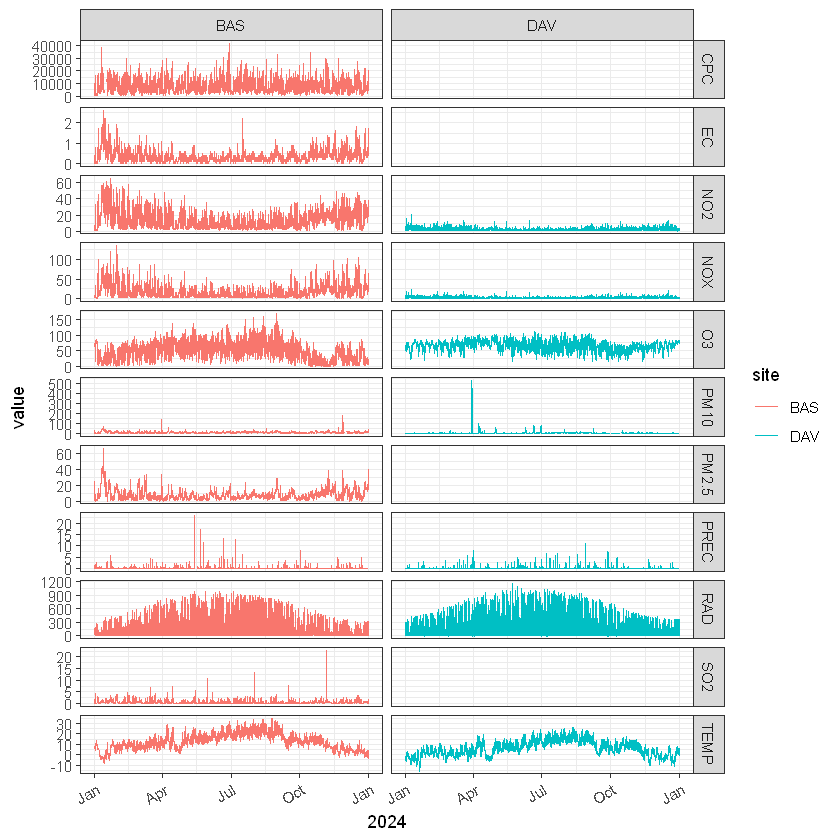

In [94]:
  ggplot(all_data_lf)+                                        # `lf` is the data frame
  facet_grid(variable~site, scale="free_y")+         # panels created out of these variables
  geom_line(aes(datetime, value, color=site))+       # plot `value` vs. `time` as lines
  scale_x_datetime("2024", date_labels = "%b") +
  theme(axis.text.x=element_text(angle=30, hjust=1)) # rotate x-axis labels

## geom_line counts the segments and not the actual number of NA values removed

In [95]:
## There are more NA values than segments because we have consecutive Na Values
sum(is.na(all_data_lf$value))

[1] 36281

In [96]:
sum(is.na(all_data_lf$value))

[1] 36281

In [97]:
colSums(is.na(all_data_df))

site datetime     year    month      day     hour  dayofwk  daytype 
       0        0        0        0        0        0        0        0 
  season       O3      NO2     PM10      NOX     TEMP     PREC      RAD 
       0       85       96      211       96        0       73        0 
     SO2    PM2.5       EC      CPC 
    8852     9065     8832     8971

In [98]:
subset_data <- all_data_df[grep("BAS", all_data_df$site), ]  # Select rows containing "BAS"
na_count_BAS <- colSums(is.na(subset_data))  # Count NA values per column
na_count_BAS

site datetime     year    month      day     hour  dayofwk  daytype 
       0        0        0        0        0        0        0        0 
  season       O3      NO2     PM10      NOX     TEMP     PREC      RAD 
       0       67       74      113       74        0       72        0 
     SO2    PM2.5       EC      CPC 
      68      281       48      187

In [99]:
subset_data <- all_data_df[grep("BAS", all_data_df$site), ]  # Select rows containing "BAS"
na_count_BAS <- colSums(is.na(subset_data))  # Count NA values per column
na_count_BAS

site datetime     year    month      day     hour  dayofwk  daytype 
       0        0        0        0        0        0        0        0 
  season       O3      NO2     PM10      NOX     TEMP     PREC      RAD 
       0       67       74      113       74        0       72        0 
     SO2    PM2.5       EC      CPC 
      68      281       48      187

## Seasonal Averages

### Tests

Warning message:
"Removed 36281 rows containing non-finite values (`stat_boxplot()`)."


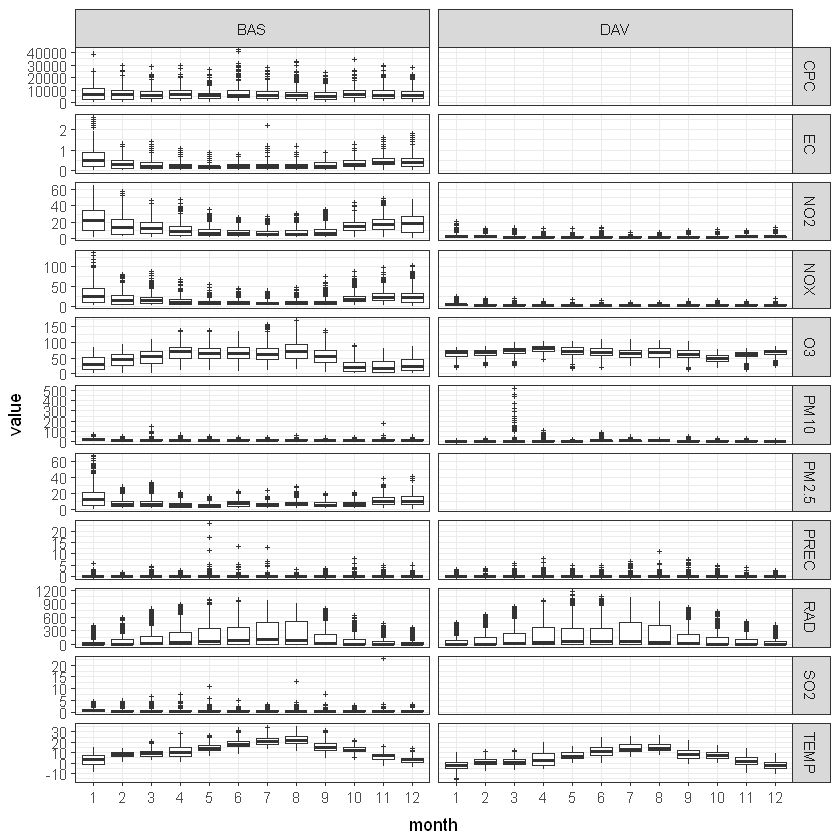

In [100]:
#monthly display example
all_data_lf %>% 
  mutate(month = factor(month)) %>%
  ggplot +
  facet_grid(variable ~ site, scale = "free_y") +
  geom_boxplot(aes(month, value), outlier.size = 0.5, outlier.shape = 3)

Warning message:
"Removed 36281 rows containing non-finite values (`stat_boxplot()`)."


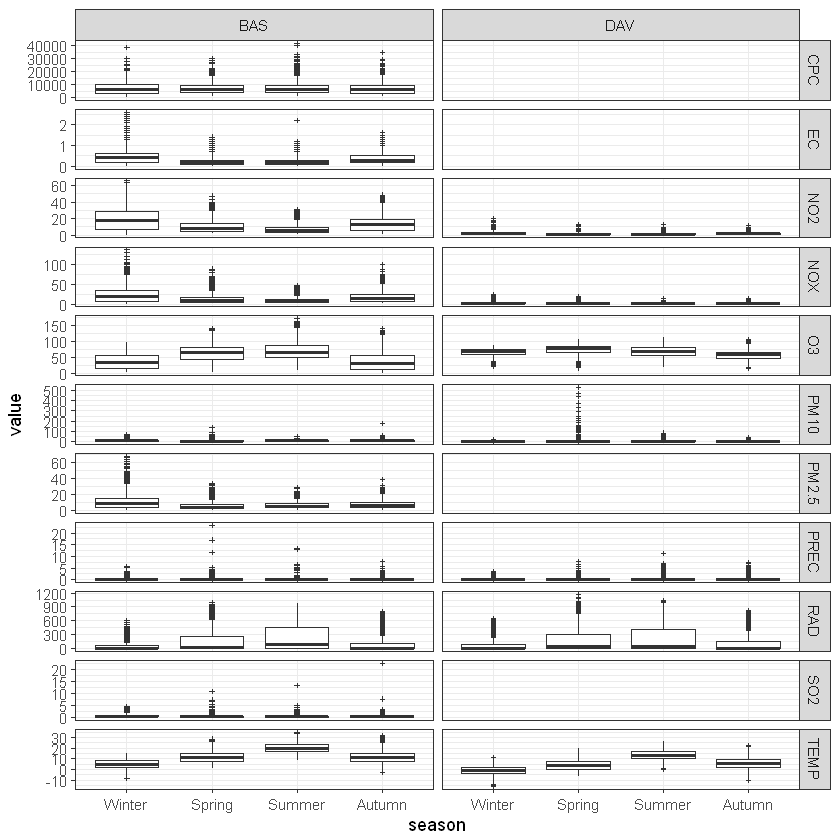

In [101]:
# separated by site
all_data_lf %>% 
  #mutate(month = factor(month)) %>%
  ggplot +
  facet_grid(variable ~ site, scale = "free_y") +
  geom_boxplot(aes(season, value), outlier.size = 0.5, outlier.shape = 3)

### Actual results

In [184]:
library(dplyr)

# Calculate the average values excluding certain variables
avg_values <- all_data_lf %>%
  filter(!variable %in% c("CPC", "EC", "NOX")) %>%  # Exclude these variables
  group_by(site, season, variable) %>%
  summarise(mean_value = mean(value, na.rm = TRUE)) %>%
  ungroup()

# Print the table to the console
avg_values

# Optionally, write the table to a CSV file
write.csv(avg_values, "outputs/seasonal_average_values.csv", row.names = FALSE)

`summarise()` has grouped output by 'site', 'season'. You can override using the `.groups`
argument.


site,season,variable,mean_value
<chr>,<fct>,<chr>,<dbl>
BAS,Winter,NO2,19.13648331
BAS,Winter,O3,36.18704397
BAS,Winter,PM10,12.82572227
BAS,Winter,PM2.5,11.10361620
BAS,Winter,PREC,0.07614469
BAS,Winter,RAD,49.77142857
BAS,Winter,SO2,0.68165653
BAS,Winter,TEMP,4.68704212
BAS,Spring,NO2,10.57496599


Warning message:
"Removed 18382 rows containing non-finite values (`stat_boxplot()`)."
Warning message:
"Removed 18382 rows containing non-finite values (`stat_boxplot()`)."


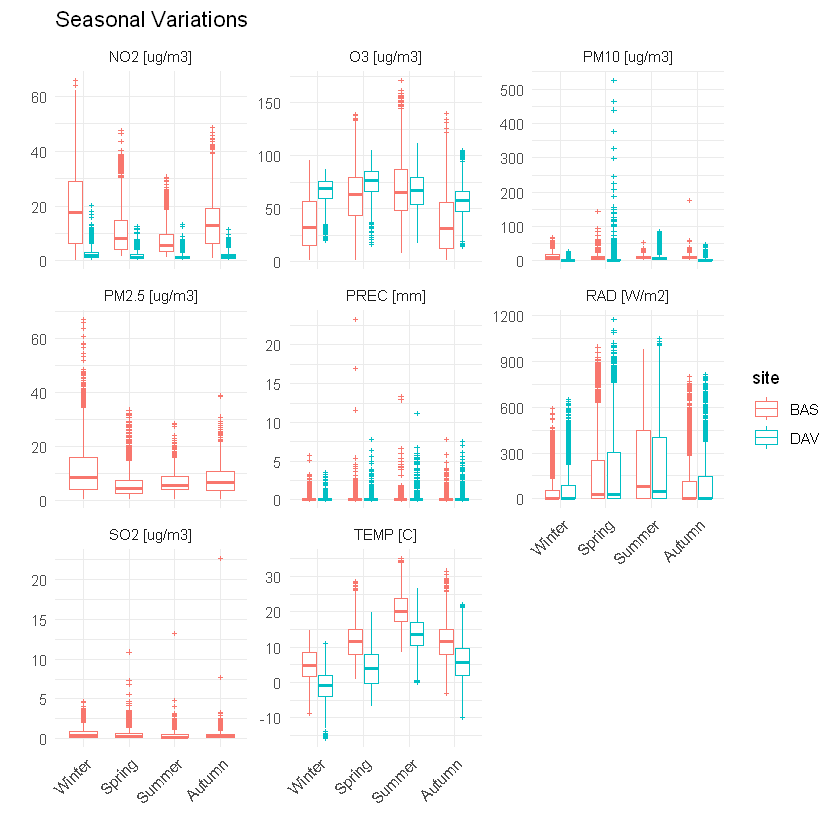

In [180]:
## Saving seasonal plot 
seasonal_variations <- all_data_lf %>% 
  filter(!variable %in% c("CPC", "EC", "NOX"))  # Exclude these variables
  

seasonal_averages_plot <- ggplot(seasonal_variations) +
  facet_wrap(~ variable, scales = "free_y", labeller = labeller(
    variable = c(
      "NO2" =  "NO2 [ug/m3]",
      "O3" = "O3 [ug/m3]",
      "PM10" = "PM10 [ug/m3]",
      "PM2.5" = "PM2.5 [ug/m3]",
      "PREC" = "PREC [mm]",
      "RAD" = "RAD [W/m2]",
      "SO2" = "SO2 [ug/m3]",
      "TEMP" = "TEMP [C]"
    ))) +  # Facet by variable only
  geom_boxplot(
    aes(x = season, 
        y = value, 
        color = site, 
        #fill = season
       ), 
    outlier.size = 0.5, 
    outlier.shape = 3,
    width = 0.6,  # Default is 0.5; increase this to widen the box
    position = position_dodge(width = 0.7)  # Controls spacing between site groups
  ) +
    labs(
    x = "",  # Label for the x-axis
    y = "",  # Label for the y-axis
    title = "Seasonal Variations"  # Title for the plot
  ) +
  theme_minimal() + theme(axis.text.x = element_text(angle = 45, hjust = 1))
seasonal_averages_plot

ggsave("outputs/seasonal_variations.jpeg", plot = seasonal_averages_plot, width = 9, height = 6, dpi = 300)

## Weekdays vs Weekends

### Test

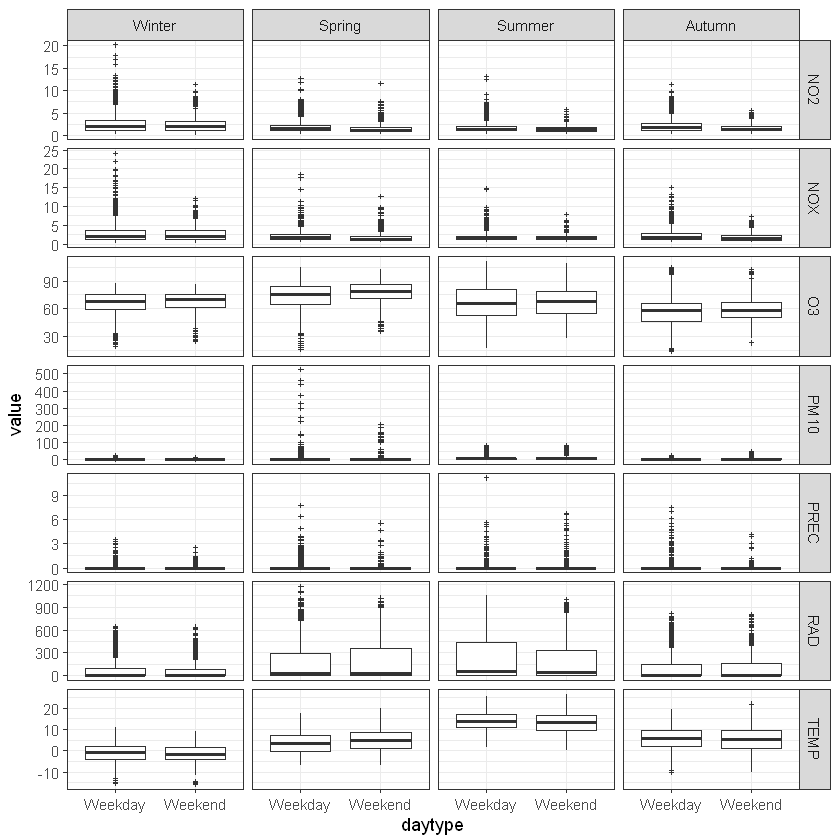

In [104]:
# DAVOS 
all_data_lf %>%
  filter(site=="DAV" & !is.na(value) & !is.na(season)) %>%
  ggplot +
  facet_grid(variable ~ season, scale = "free_y") +
  geom_boxplot(aes(daytype, value), outlier.size = 0.5, outlier.shape = 3)

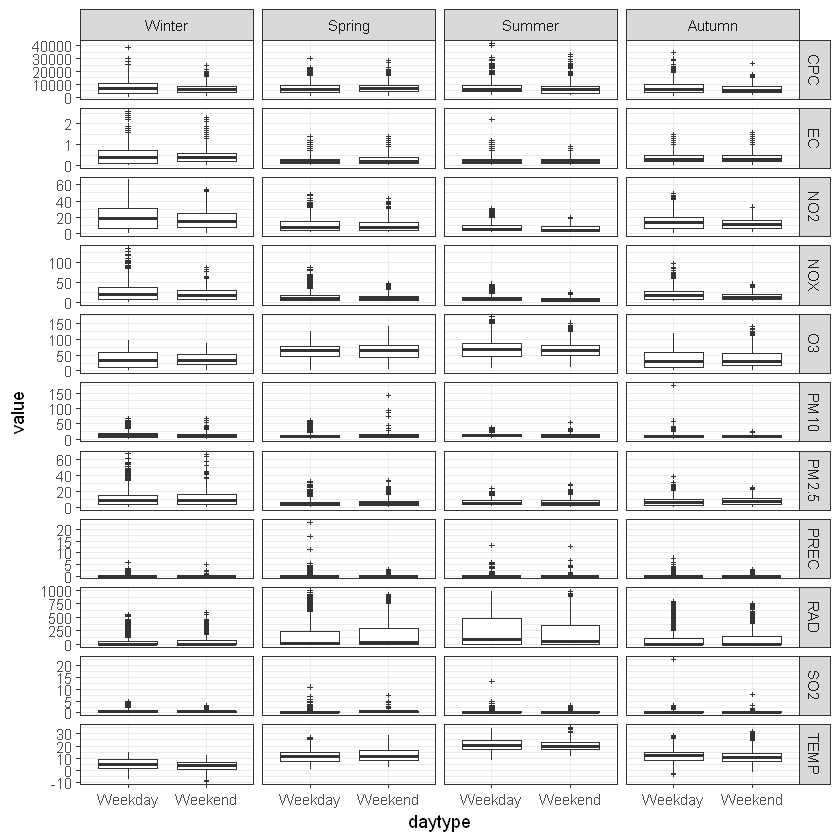

In [105]:
# BASEL
all_data_lf %>%
  filter(site == "BAS" & !is.na(value) & !is.na(season)) %>%
  ggplot +
  facet_grid(variable ~ season, scale = "free_y") +
  geom_boxplot(aes(daytype, value), outlier.size = 0.5, outlier.shape = 3)

### Actual results

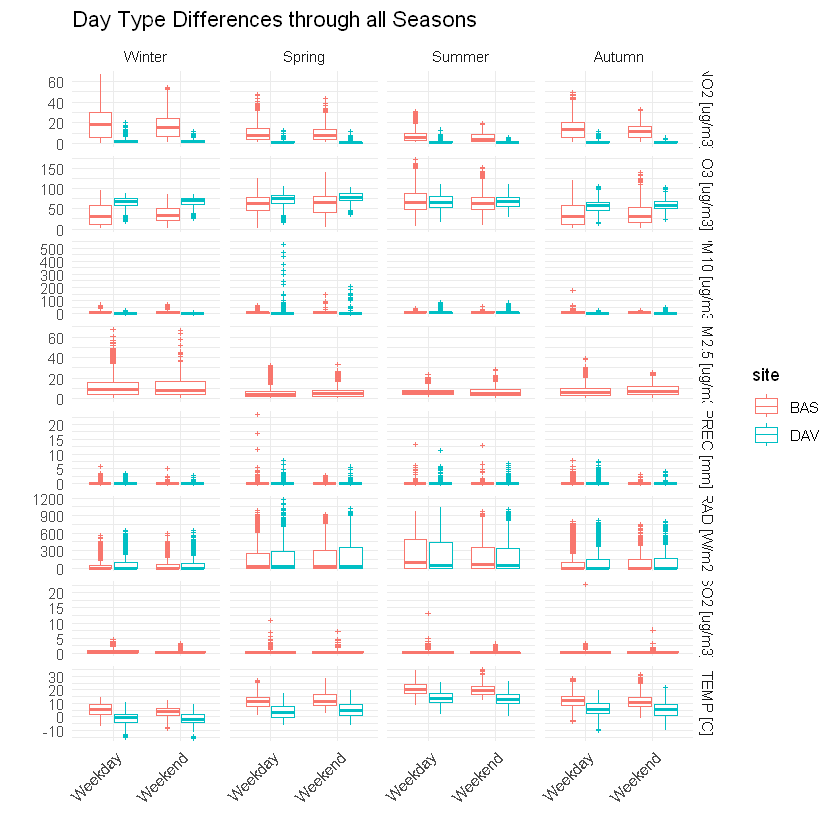

In [183]:
# both sites on the same graph
daytype<-all_data_lf %>%
  filter(!is.na(value) & !is.na(season) & !variable %in% c("CPC", "EC", "NOX"))
  
daytype_plot<-ggplot(daytype) +
  facet_grid(variable ~ season, scales = "free_y", labeller = labeller(
    variable = c(
      "NO2" =  "NO2 [ug/m3]",
      "O3" = "O3 [ug/m3]",
      "PM10" = "PM10 [ug/m3]",
      "PM2.5" = "PM2.5 [ug/m3]",
      "PREC" = "PREC [mm]",
      "RAD" = "RAD [W/m2]",
      "SO2" = "SO2 [ug/m3]",
      "TEMP" = "TEMP [C]"
    )
  )) + 
  geom_boxplot(
    aes(x = daytype, y = value, color = site),
    outlier.size = 0.5, 
    outlier.shape = 3
  ) +
    labs(
    x = "",  # Label for the x-axis
    y = "",  # Label for the y-axis
    title = "Day Type Differences through all Seasons"  # Title for the plot
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

daytype_plot

ggsave("outputs/daytype.jpeg", plot = daytype_plot, width = 9, height = 9, dpi = 300)

## Precipitation average variations

### Tests

`summarise()` has grouped output by 'daytype', 'variable'. You can override using the
`.groups` argument.


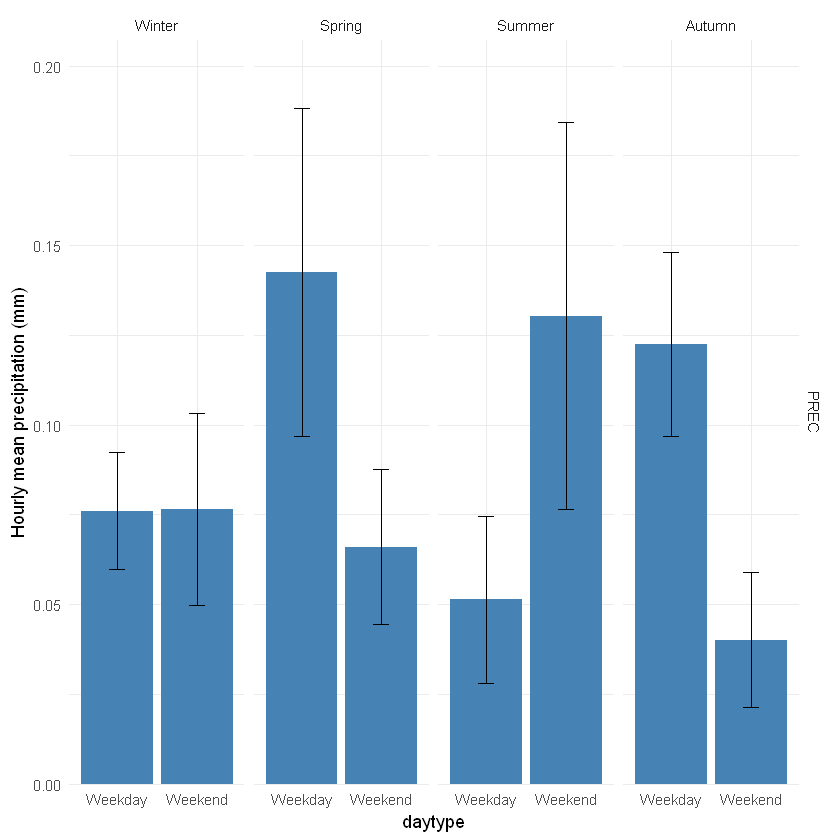

In [160]:
#  precipitation average in BASEL
all_data_lf %>%
  filter(site == "BAS" & !is.na(value) & variable == "PREC" & !is.na(season)) %>%
  group_by(daytype, variable, season) %>%
  summarise(
    mean_value = mean(value, na.rm = TRUE),
    sd_value = sd(value, na.rm = TRUE),
    n = sum(!is.na(value)),  # Sample size (excluding NA)
    se_value = sd_value / sqrt(n),  # Standard error
    ci_value = qt(0.975, df = n - 1) * se_value  # 95% Confidence Interval
  ) %>%
  ggplot(aes(daytype, mean_value)) +
  facet_grid(variable ~ season, scales = "free_y") +
  geom_bar(stat = "identity", show.legend = FALSE, fill = "steelblue") +  # Mean values as bars
  geom_errorbar(aes(ymin = mean_value - ci_value, ymax = mean_value + ci_value), 
                width = 0.2, color = "black") +  # 95% CI error bars
  scale_y_continuous("Hourly mean precipitation (mm)", expand = expansion(mult = c(0, 0.1))) +
  theme_minimal()


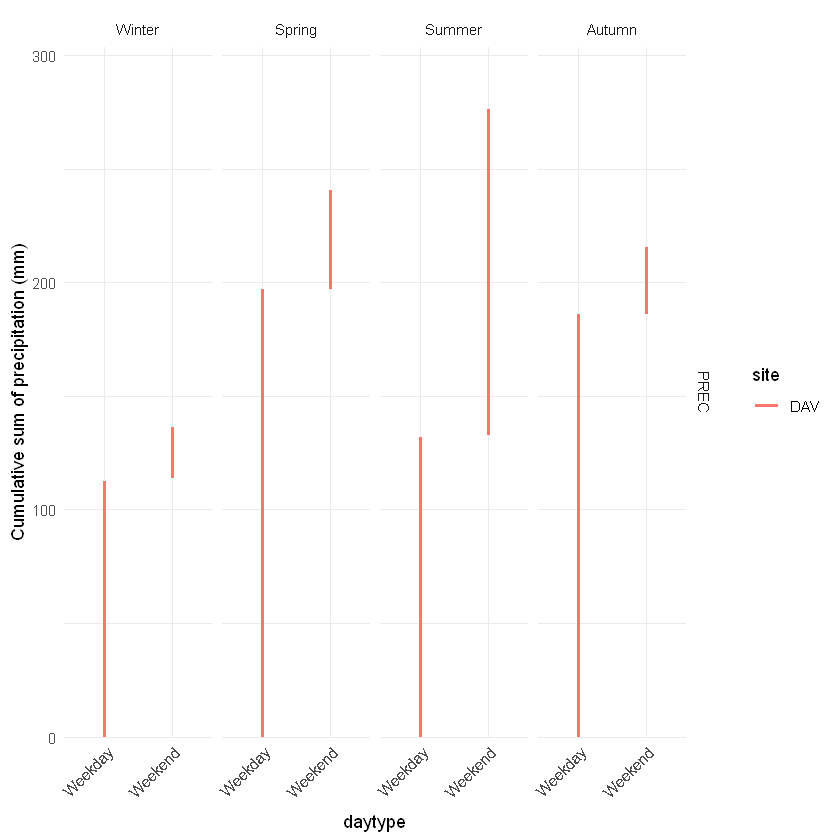

In [164]:
library(dplyr)
library(ggplot2)

# Calculate the cumulative sum of precipitation for site "DAV" and variable "PREC"
cumsum_data <- all_data_lf %>%
  filter(site == "DAV" & !is.na(value) & variable == "PREC" & !is.na(season)) %>%
  arrange(daytype) %>%  # Ensure data is ordered by daytype (time)
  group_by(season) %>%  # If you want to plot by season separately
  mutate(cumsum_value = cumsum(value)) %>%  # Calculate cumulative sum
  ungroup()

# Create the plot
precipitation_plot <- ggplot(cumsum_data, aes(x = daytype, y = cumsum_value)) +
  facet_grid(variable ~ season, scales = "free_y") +  # Facet by season and variable
  geom_line(aes(color = site), size = 1) +  # Line plot to show cumulative precipitation
  scale_y_continuous("Cumulative sum of precipitation (mm)", expand = expansion(mult = c(0, 0.1))) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))  # Rotate x-axis labels if necessary

# Print the plot
precipitation_plot



### Actual results

`summarise()` has grouped output by 'daytype', 'variable', 'season'. You can override using
the `.groups` argument.


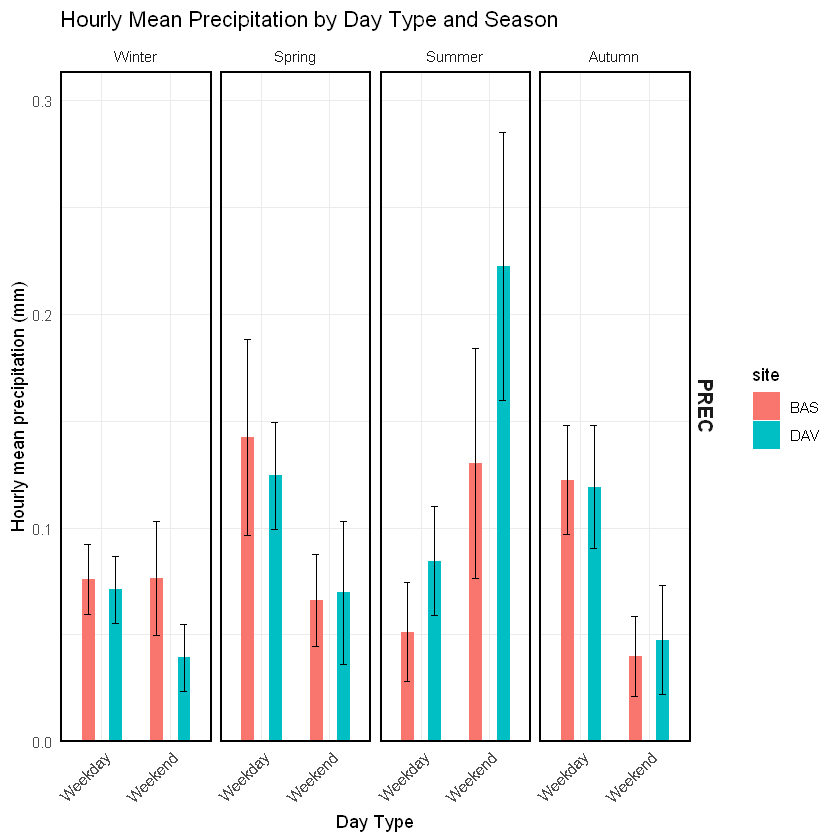

In [176]:
Precipitation_data <- all_data_lf %>%
  filter(!is.na(value) & variable == "PREC" & !is.na(season)) %>%
  group_by(daytype, variable, season, site) %>%
  summarise(
    mean_value = mean(value, na.rm = TRUE),
    sd_value = sd(value, na.rm = TRUE),
    n = sum(!is.na(value)),  # Sample size (excluding NA)
    se_value = sd_value / sqrt(n),  # Standard error
    ci_value = qt(0.975, df = n - 1) * se_value  # 95% Confidence Interval
  )

precipitations_plot_1 <-ggplot(Precipitation_data,
    aes(
    x = daytype, 
    y = mean_value, 
    color = site,
    fill=site
  )
) +
  facet_grid(variable ~ season, scales = "free_y") +
  # Adjust the dodge width for bars and error bars to avoid superimposition
  geom_bar(
    stat = "identity", 
    show.legend = TRUE, 
    position = position_dodge(width = 0.8),  # Separate bars for each site
    width = 0.35  # Adjust bar width to avoid overlap
  ) +  # Mean values as bars
  geom_errorbar(
    aes(ymin = mean_value - ci_value, ymax = mean_value + ci_value), 
    width = 0.2, 
    position = position_dodge(width = 0.8),  # Align error bars with the bars for each site
    color = "black"
  ) +  # 95% CI error bars
  labs(
    x = "Day Type",  # Label for the x-axis
    y = "Log10 of Precipitation (mm)",  # Label for the y-axis
    title = "Hourly Mean Precipitation by Day Type and Season"  # Title for the plot
  ) +
  scale_y_continuous("Hourly mean precipitation (mm)", expand = expansion(mult = c(0, 0.1))) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    strip.text.y = element_text(size = 12, face = "bold"),  # Make facet labels bolder
    panel.border = element_rect(color = "black", fill = NA, size = 1)  # Add box around each facet
  )

precipitations_plot_1

ggsave("outputs/precipitations_1.jpeg", plot = precipitations_plot_1, width = 6, height = 5, dpi = 300)


Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 15456 rows containing non-finite values (`stat_boxplot()`)."
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 15456 rows containing non-finite values (`stat_boxplot()`)."


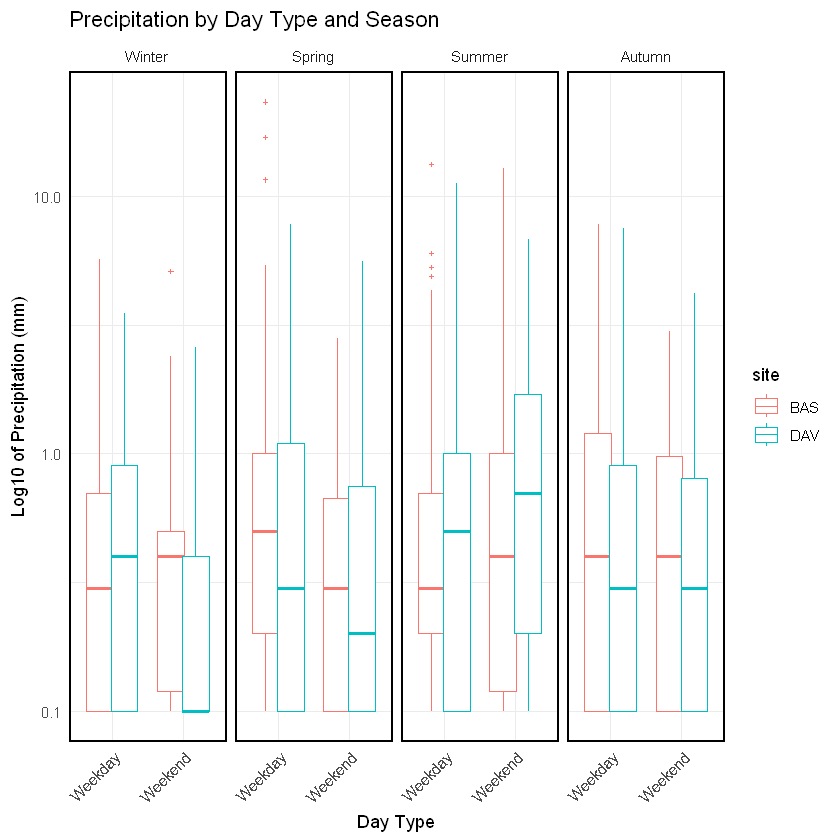

In [172]:
library(ggplot2)
library(dplyr)

# Filter the data for the PREC variable
daytype <- all_data_lf %>%
  filter(!is.na(value) & !is.na(season) & variable == "PREC")

# Create the plot for PREC only, with a log y scale and clear separation of seasons
daytype_plot <- ggplot(daytype) +
  facet_grid(~ season, scales = "free_y", labeller = labeller(
    variable = c(
      "PREC" = "PREC [mm]"
    )
  )) + 
  # Add the rectangle around each season facet
  geom_boxplot(
    aes(x = daytype, y = value, color = site),
    outlier.size = 0.5, 
    outlier.shape = 3,
    position = position_dodge(width = 0.7)  # Separate the boxplots for each season
  ) +
  scale_y_log10() +  # Apply log scale to y-axis
  labs(
    x = "Day Type",  # Label for the x-axis
    y = "Log10 of Precipitation (mm)",  # Label for the y-axis
    title = "Precipitation Distribution by Day Type and Season"  # Title for the plot
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    strip.text.y = element_text(size = 12, face = "bold"),  # Make facet labels bolder
    panel.border = element_rect(color = "black", fill = NA, size = 1)  # Add box around each facet
  )

# Print the plot
daytype_plot

# Save the plot
ggsave("outputs/daytype_prec_log_separated_seasons_with_boxes.jpeg", plot = daytype_plot, width = 6, height = 5, dpi = 300)


## Cummulative precipitaiton variations

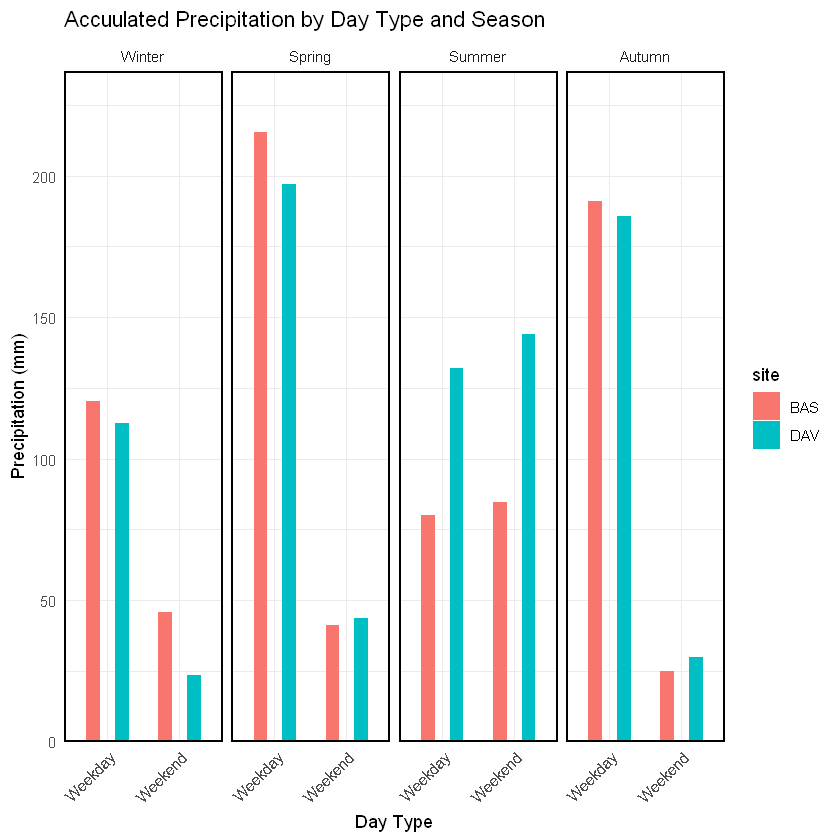

In [175]:
# Filter out NA values and calculate cumulative sum using reframe()
Precipitation_cumsum_data <- all_data_lf %>%
  filter(!is.na(value) & variable == "PREC" & !is.na(season)) %>%
  group_by(daytype, season, site) %>%
  reframe(
    cumsum_value = cumsum(value)  # Compute cumulative sum for each group
  )

# Create the plot
precipitations_plot_2 <- ggplot(Precipitation_cumsum_data, aes(
    x = daytype, 
    y = cumsum_value, 
    color = site,
    fill = site
  )) +
  facet_grid(~ season, scales = "free_y") +
  geom_bar(
    stat = "identity", 
    show.legend = TRUE, 
    position = position_dodge(width = 0.8),  # Separate bars for each site
    width = 0.35  # Adjust bar width to avoid overlap
  ) +
  scale_y_continuous("Precipitation (mm)", expand = expansion(mult = c(0, 0.1))) +  # Adjust label to reflect cumulative values
  theme_minimal() +
    labs(
    x = "Day Type",  # Label for the x-axis
    y = "Precipitation (mm)",  # Label for the y-axis
    title = "Accuulated Precipitation by Day Type and Season"  # Title for the plot
  ) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    strip.text.y = element_text(size = 12, face = "bold"),  # Make facet labels bolder
    panel.border = element_rect(color = "black", fill = NA, size = 1)  # Add box around each facet
  )

# Print the plot
precipitations_plot_2

ggsave("outputs/accumulated_precipitations_1.jpeg", plot = precipitations_plot_2, width = 6, height = 5, dpi = 300)
